In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
import urllib.request
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
from jax.scipy.special import expit, logsumexp
import time

from src.load_data import load_traintest_sparseclass

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [4]:
def download_parkinsons_data(save_path='data/parkinsons.data'):
    """
    Download the Parkinson's dataset from the UCI repository if it does not exist locally.
    """
    if not os.path.exists('data'):
        os.makedirs('data')
    if not os.path.exists(save_path):
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
        print(f"Downloading Parkinson's dataset from {url} ...")
        urllib.request.urlretrieve(url, save_path)
        print("Parkinson's dataset downloaded.")
    else:
        print("Parkinson's dataset already exists.")
    return save_path

In [5]:
def get_feature_names(dataset):
    """
    Get feature names for the dataset.
    """
    if dataset == "breast":
        # Get feature names from sklearn
        names = load_breast_cancer().feature_names
    elif dataset == "parkinsons":
        # Read feature names from the CSV header
        data = pd.read_csv('data/parkinsons.data')
        names = data.drop(columns=['name', 'status']).columns.tolist()
    else:
        raise ValueError("Invalid dataset. Choose 'breast' or 'parkinsons'")
    
    return names

# Define log-prior functions
@jit
def log_prior_horseshoe(beta, intercept, tau, lambdas):
    """
    Compute the log prior for horseshoe prior on regression coefficients.
    """
    # Horseshoe prior on regression coefficients
    beta_prior = jnp.sum(jax.scipy.stats.norm.logpdf(beta, 0.0, tau * lambdas))
    
    # Normal prior on intercept
    intercept_prior = jax.scipy.stats.norm.logpdf(intercept, 0.0, 10.0)
    
    # Half-Cauchy prior on global shrinkage parameter
    tau_prior = jax.scipy.stats.cauchy.logpdf(tau, 0.0, 1.0) + jnp.log(2.0) * (tau > 0)
    
    # Half-Cauchy prior on local shrinkage parameters
    lambda_prior = jnp.sum(jax.scipy.stats.cauchy.logpdf(lambdas, 0.0, 1.0)) + jnp.log(2.0) * jnp.sum(lambdas > 0)
    
    return beta_prior + intercept_prior + tau_prior + lambda_prior

@jit
def log_likelihood(beta, intercept, X, y):
    """
    Compute the log likelihood for a Bernoulli logistic regression model.
    """
    logits = jnp.dot(X, beta) + intercept
    log_probs = jnp.where(y == 1, 
                          jax.nn.log_sigmoid(logits), 
                          jax.nn.log_sigmoid(-logits))
    return jnp.sum(log_probs)

@jit
def log_posterior(params, X, y):
    """
    Compute the log posterior (unnormalized).
    
    Args:
        params: Dictionary containing model parameters
        X: Feature matrix
        y: Target vector
    """
    beta = params['beta']
    intercept = params['intercept']
    tau = params['tau']
    lambdas = params['lambdas']
    
    # Compute log prior and log likelihood
    log_prior = log_prior_horseshoe(beta, intercept, tau, lambdas)
    log_like = log_likelihood(beta, intercept, X, y)
    
    # Return unnormalized log posterior
    return log_prior + log_like

# Define MCMC functions
def initialize_params(num_features, rng_key):
    """
    Initialize model parameters.
    """
    key1, key2, key3, key4 = random.split(rng_key, 4)
    
    # Initialize parameters to small random values
    beta = random.normal(key1, (num_features,)) * 0.1
    intercept = random.normal(key2, ()) * 0.1
    tau = jnp.abs(random.normal(key3, ())) * 0.1 + 0.01  # Ensure positivity
    lambdas = jnp.abs(random.normal(key4, (num_features,))) * 0.1 + 0.01  # Ensure positivity
    
    return {
        'beta': beta,
        'intercept': intercept,
        'tau': tau,
        'lambdas': lambdas
    }

def metropolis_hastings_step(params, log_post_fn, step_sizes, rng_key):
    """
    Perform one step of the Metropolis-Hastings algorithm.
    """
    # Current log posterior
    current_log_post = log_post_fn(params)
    
    # Create proposal by adding normal noise to parameters
    keys = random.split(rng_key, 5)
    
    # Generate proposals with adaptable step sizes
    beta_proposal = params['beta'] + random.normal(keys[0], params['beta'].shape) * step_sizes['beta']
    intercept_proposal = params['intercept'] + random.normal(keys[1], ()) * step_sizes['intercept']
    tau_proposal = jnp.abs(params['tau'] + random.normal(keys[2], ()) * step_sizes['tau'])
    lambdas_proposal = jnp.abs(params['lambdas'] + random.normal(keys[3], params['lambdas'].shape) * step_sizes['lambdas'])
    
    # Combined proposal
    proposal = {
        'beta': beta_proposal,
        'intercept': intercept_proposal,
        'tau': tau_proposal,
        'lambdas': lambdas_proposal
    }
    
    # Proposed log posterior
    proposed_log_post = log_post_fn(proposal)
    
    # Calculate acceptance probability
    log_accept_ratio = proposed_log_post - current_log_post
    
    # Accept or reject
    accept = jnp.log(random.uniform(keys[4], ())) < log_accept_ratio
    
    # Return new parameters and acceptance
    new_params = {
        'beta': jnp.where(accept, proposal['beta'], params['beta']),
        'intercept': jnp.where(accept, proposal['intercept'], params['intercept']),
        'tau': jnp.where(accept, proposal['tau'], params['tau']),
        'lambdas': jnp.where(accept, proposal['lambdas'], params['lambdas'])
    }
    
    return new_params, accept

def run_mcmc(log_post_fn, initial_params, n_steps, step_sizes, rng_key, burnin=0.2, adapt_interval=100):
    """
    Run MCMC sampling using Metropolis-Hastings.
    """
    # Initialize
    params = initial_params
    n_burnin = int(n_steps * burnin)
    
    # Storage for samples and diagnostics
    samples = []
    acceptances = []
    
    # Calculate total parameters to adaptively tune step sizes
    n_params = 2 + 2 * len(initial_params['beta'])  # beta, intercept, tau, lambdas
    
    # Target acceptance rate
    target_accept = 0.234  # Optimal acceptance rate for high-dim problems
    
    # Use closure to fix X and y
    def log_post_wrapper(p):
        return log_post_fn(p)
    
    # Run MCMC
    for i in range(n_steps):
        # Split the random key
        rng_key, subkey = random.split(rng_key)
        
        # Perform Metropolis-Hastings step
        params, accepted = metropolis_hastings_step(params, log_post_wrapper, step_sizes, subkey)
        
        # Store samples after burn-in
        if i >= n_burnin:
            samples.append(params)
        
        # Store acceptance for adaptation
        acceptances.append(accepted)
        
        # Adapt step sizes at regular intervals during burn-in
        if i < n_burnin and i > 0 and i % adapt_interval == 0:
            # Calculate recent acceptance rate
            recent_accept_rate = jnp.mean(jnp.array(acceptances[-adapt_interval:]))
            
            # Adjust step sizes based on acceptance rate
            adjust_factor = jnp.exp(min(0.01, 1.0/jnp.sqrt(i/adapt_interval)) * (recent_accept_rate - target_accept))
            
            step_sizes = {
                'beta': step_sizes['beta'] * adjust_factor,
                'intercept': step_sizes['intercept'] * adjust_factor,
                'tau': step_sizes['tau'] * adjust_factor,
                'lambdas': step_sizes['lambdas'] * adjust_factor
            }
            
            if i % (10 * adapt_interval) == 0:
                print(f"Step {i}, acceptance rate: {recent_accept_rate:.3f}, adjusted step sizes")
        
        # Print progress
        if i % 500 == 0:
            print(f"Step {i}/{n_steps}")
    
    # Calculate overall acceptance rate
    accept_rate = jnp.mean(jnp.array(acceptances[n_burnin:]))
    print(f"Acceptance rate after burn-in: {accept_rate:.3f}")
    
    return samples, accept_rate

def extract_posterior_samples(mcmc_samples, n_features):
    """
    Extract and organize posterior samples.
    """
    n_samples = len(mcmc_samples)
    
    # Initialize arrays
    beta_samples = np.zeros((n_samples, n_features))
    intercept_samples = np.zeros(n_samples)
    tau_samples = np.zeros(n_samples)
    lambda_samples = np.zeros((n_samples, n_features))
    
    # Fill arrays
    for i, sample in enumerate(mcmc_samples):
        beta_samples[i] = sample['beta']
        intercept_samples[i] = sample['intercept']
        tau_samples[i] = sample['tau']
        lambda_samples[i] = sample['lambdas']
    
    # Create dictionary of samples
    samples = {
        'beta': beta_samples,
        'intercept': intercept_samples,
        'tau': tau_samples,
        'lambda': lambda_samples
    }
    
    return samples

def save_posterior_samples(samples, dataset_name="parkinsons", folder="samples"):
    """
    Save the posterior samples in the required format for conformal prediction.
    """
    # Create folder if it doesn't exist
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    # Extract beta and intercept
    beta_samples = samples['beta']
    intercept_samples = samples['intercept']
    
    # Save as numpy arrays
    np.save(f"{folder}/beta_post_sparseclass_{dataset_name}.npy", beta_samples)
    np.save(f"{folder}/intercept_post_sparseclass_{dataset_name}.npy", intercept_samples)
    
    print(f"Saved posterior samples to {folder}/ directory.")
    
    return beta_samples, intercept_samples

def plot_trace(samples, feature_names, max_features=5):
    """
    Plot trace plots for key parameters.
    """
    n_samples = samples['beta'].shape[0]
    x_range = np.arange(n_samples)
    
    # Create figure
    fig, axes = plt.subplots(2 + min(max_features, len(feature_names)), 1, figsize=(10, 8), sharex=True)
    
    # Plot intercept
    axes[0].plot(x_range, samples['intercept'])
    axes[0].set_title('Intercept')
    axes[0].set_ylabel('Value')
    
    # Plot tau (global shrinkage)
    axes[1].plot(x_range, samples['tau'])
    axes[1].set_title('Tau (Global Shrinkage)')
    axes[1].set_ylabel('Value')
    
    # Plot top few beta coefficients
    beta_means = np.abs(samples['beta'].mean(axis=0))
    top_indices = np.argsort(beta_means)[::-1][:max_features]
    
    for i, idx in enumerate(top_indices):
        axes[i+2].plot(x_range, samples['beta'][:, idx])
        axes[i+2].set_title(f'Beta: {feature_names[idx]}')
        axes[i+2].set_ylabel('Value')
    
    axes[-1].set_xlabel('Sample')
    plt.tight_layout()
    plt.show()

def plot_feature_importance(samples, feature_names, top_n=10):
    """
    Plot feature importance based on posterior distributions
    """
    # Calculate posterior means and standard deviations
    beta_means = samples['beta'].mean(axis=0)
    beta_stds = samples['beta'].std(axis=0)
    
    # Calculate probability of coefficient being positive
    prob_positive = (samples['beta'] > 0).mean(axis=0)
    
    # Get indices of features sorted by absolute effect size
    sorted_idx = np.argsort(np.abs(beta_means))[::-1]
    top_features = [feature_names[i] for i in sorted_idx[:top_n]]
    top_means = [beta_means[i] for i in sorted_idx[:top_n]]
    top_stds = [beta_stds[i] for i in sorted_idx[:top_n]]
    top_probs = [prob_positive[i] for i in sorted_idx[:top_n]]
    
    # Plot
    plt.figure(figsize=(12, 8))
    colors = ["blue" if mean > 0 else "red" for mean in top_means]
    y_pos = np.arange(len(top_features))
    
    plt.barh(y_pos, top_means, xerr=top_stds, align='center', color=colors, alpha=0.7)
    plt.yticks(y_pos, top_features)
    plt.xlabel('Coefficient Value')
    plt.title('Top Features by Importance')
    
    # Add probability annotations
    for i, prob in enumerate(top_probs):
        plt.text(0, i, f"{prob:.2f}", verticalalignment='center')
    
    plt.tight_layout()
    plt.show()
    
    return sorted_idx, beta_means

def evaluate_model(X_test, y_test, beta_samples, intercept_samples):
    """
    Evaluate model with posterior predictions
    """
    # Function to calculate predictions
    @jit
    def predict_proba_single(beta, intercept, X):
        logits = jnp.dot(X, beta) + intercept
        return expit(logits)
    
    # Vectorize over samples
    predict_proba_batched = vmap(predict_proba_single, in_axes=(0, 0, None))
    
    # Generate predictions for all samples
    probs = predict_proba_batched(
        jnp.array(beta_samples), 
        jnp.array(intercept_samples), 
        X_test
    )
    
    # Average over samples
    mean_probs = jnp.mean(probs, axis=0)
    
    # Convert to class labels
    y_pred = (mean_probs > 0.5).astype(int)
    
    # Calculate accuracy
    accuracy = jnp.mean(y_pred == y_test)
    
    print(f"Accuracy: {accuracy:.4f}")
    
    # Plot predictions
    plt.figure(figsize=(10, 6))
    
    # Plot individual prediction samples
    for i in range(min(100, len(beta_samples))):
        plt.scatter(range(len(y_test)), probs[i], alpha=0.01, color='gray')
    
    # Plot mean prediction
    plt.scatter(range(len(y_test)), mean_probs, color='blue', label='Mean prediction')
    
    # Plot true values
    plt.scatter(range(len(y_test)), y_test, color='red', marker='x', label='True value')
    
    # Add a horizontal line at 0.5
    plt.axhline(y=0.5, color='green', linestyle='-', alpha=0.3)
    
    plt.xlabel('Test sample index')
    plt.ylabel('Probability of breast cancer\'s')
    plt.title('Posterior Predictive Check')
    plt.legend()
    plt.show()
    
    return accuracy, mean_probs

In [6]:
def main(dataset="parkinsons", train_frac=0.8, n_steps=5000, seed=RANDOM_SEED):
    """
    Main function to run the MCMC sampling and analysis
    """
    # Ensure dataset exists for parkinsons
    if dataset == "parkinsons":
        download_parkinsons_data()
    
    # Load data using the provided function
    print(f"Loading {dataset} dataset with train fraction {train_frac}...")
    x_train, y_train, x_test, y_test, y_plot, n, d = load_traintest_sparseclass(train_frac, dataset, seed)
    
    # Get feature names
    feature_names = get_feature_names(dataset)
    
    print(f"Training data shape: {x_train.shape}")
    print(f"Number of positive cases in training: {int(np.sum(y_train))}/{len(y_train)}")
    
    # Initialize random key
    rng_key = random.PRNGKey(seed)
    
    # Initialize parameters
    initial_params = initialize_params(d, rng_key)
    
    # Define step sizes
    step_sizes = {
        'beta': 0.01 * jnp.ones(d),
        'intercept': 0.01,
        'tau': 0.01,
        'lambdas': 0.01 * jnp.ones(d)
    }
    
    # Convert numpy arrays to jax arrays
    X_train_jax = jnp.array(x_train)
    y_train_jax = jnp.array(y_train)
    X_test_jax = jnp.array(x_test)
    y_test_jax = jnp.array(y_test)
    
    # Create log posterior function with fixed X and y
    def log_post_fn(params):
        return log_posterior(params, X_train_jax, y_train_jax)
    
    # Run MCMC
    print(f"Running MCMC sampling for {n_steps} steps...")
    start_time = time.time()
    
    mcmc_samples, accept_rate = run_mcmc(
        log_post_fn, 
        initial_params, 
        n_steps, 
        step_sizes, 
        rng_key,
        burnin=0.2,
        adapt_interval=100
    )
    
    duration = time.time() - start_time
    print(f"MCMC sampling completed in {duration:.2f} seconds")
    
    # Extract posterior samples
    samples = extract_posterior_samples(mcmc_samples, d)
    
    # Save samples
    beta_samples, intercept_samples = save_posterior_samples(samples, dataset_name=dataset)
    
    # Plot trace
    plot_trace(samples, feature_names)
    
    # Plot feature importance
    sorted_idx, beta_means = plot_feature_importance(samples, feature_names)
    
    # Evaluate model
    accuracy, probs = evaluate_model(X_test_jax, y_test_jax, beta_samples, intercept_samples)
    
    print("MCMC sampling completed. The posterior samples are ready for use in conformal prediction.")
    
    return samples, x_train, x_test, y_train, y_test, y_plot, n, d, feature_names, accuracy

# Generate Parkinsons dataset

Parkinson's dataset already exists.
Loading parkinsons dataset with train fraction 0.8...
Training data shape: (156, 22)
Number of positive cases in training: 115/156
Running MCMC sampling for 5000 steps...
Step 0/5000
Step 500/5000
Step 1000/5000
Step 1500/5000
Step 2000/5000
Step 2500/5000
Step 3000/5000
Step 3500/5000
Step 4000/5000
Step 4500/5000
Acceptance rate after burn-in: 0.236
MCMC sampling completed in 3.75 seconds
Saved posterior samples to samples/ directory.


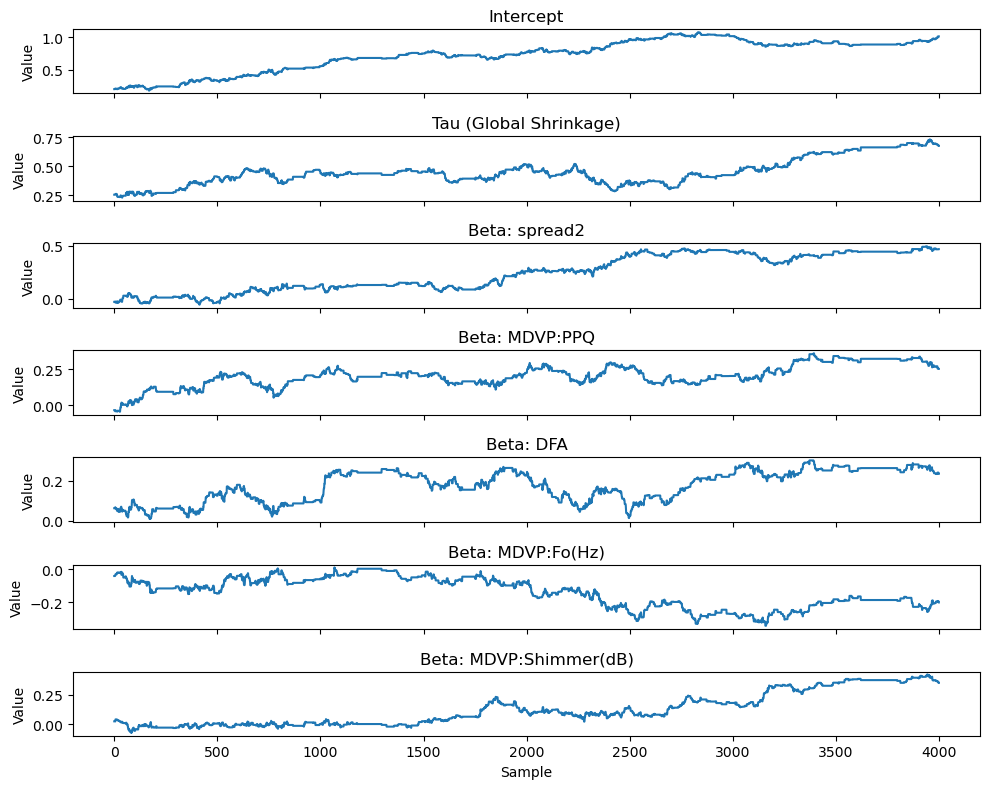

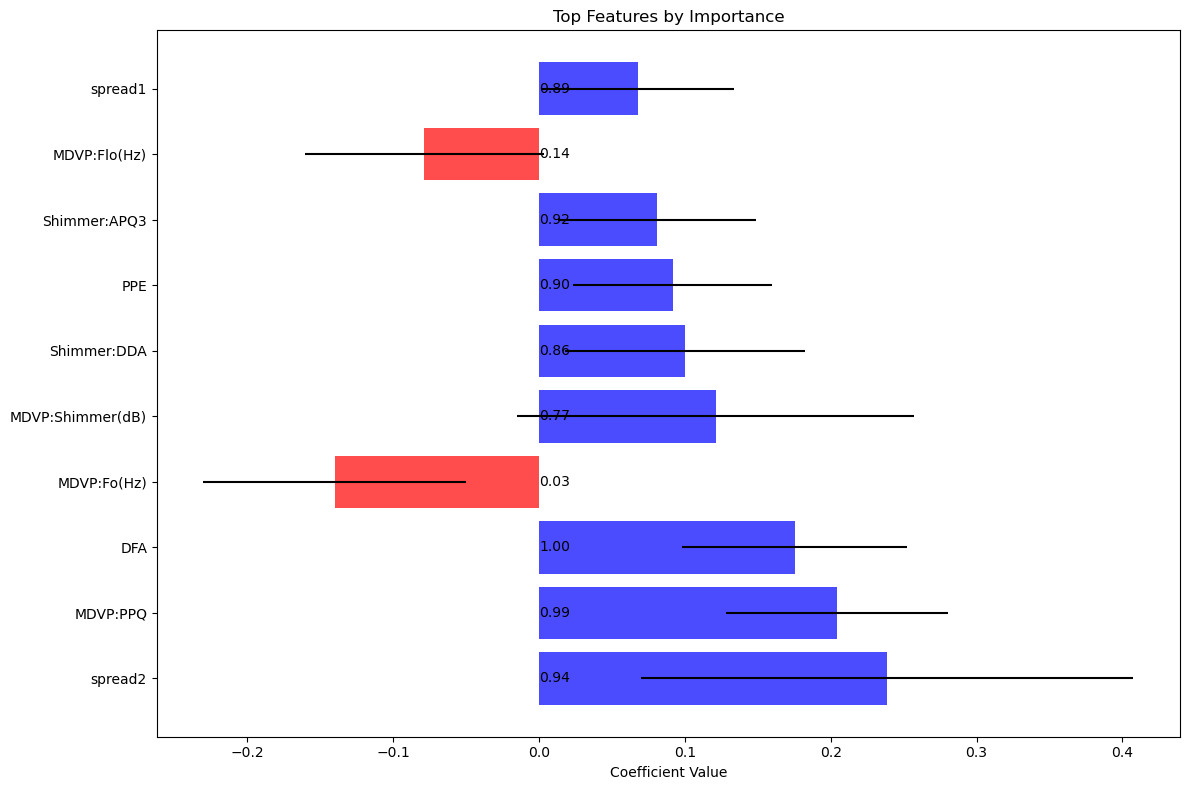

Accuracy: 0.8462


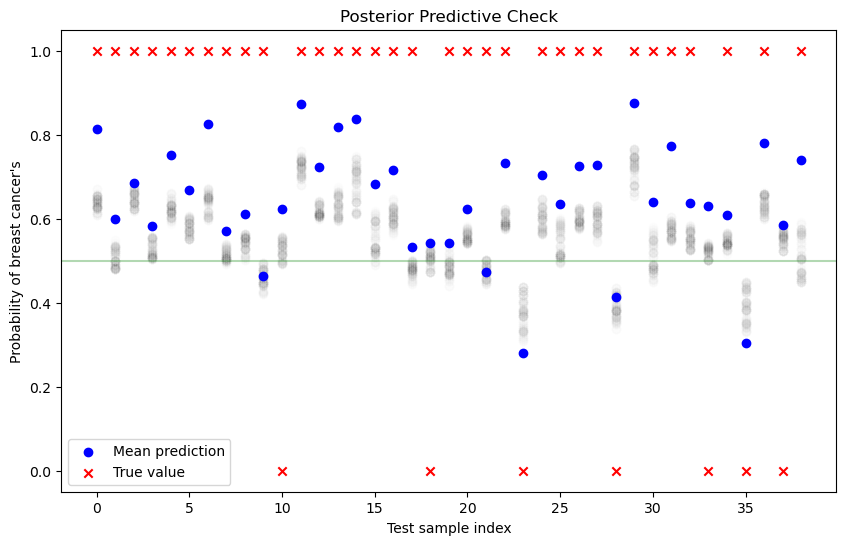

MCMC sampling completed. The posterior samples are ready for use in conformal prediction.


In [7]:
if __name__ == "__main__":
    # You can change the dataset to "breast" if needed
    main(dataset="parkinsons", train_frac=0.8, n_steps=5000, seed=RANDOM_SEED)

# Generate Breast Dataset

Loading breast dataset with train fraction 0.8...
Training data shape: (455, 30)
Number of positive cases in training: 286/455
Running MCMC sampling for 5000 steps...
Step 0/5000
Step 500/5000
Step 1000/5000
Step 1500/5000
Step 2000/5000
Step 2500/5000
Step 3000/5000
Step 3500/5000
Step 4000/5000
Step 4500/5000
Acceptance rate after burn-in: 0.388
MCMC sampling completed in 2.88 seconds
Saved posterior samples to samples/ directory.


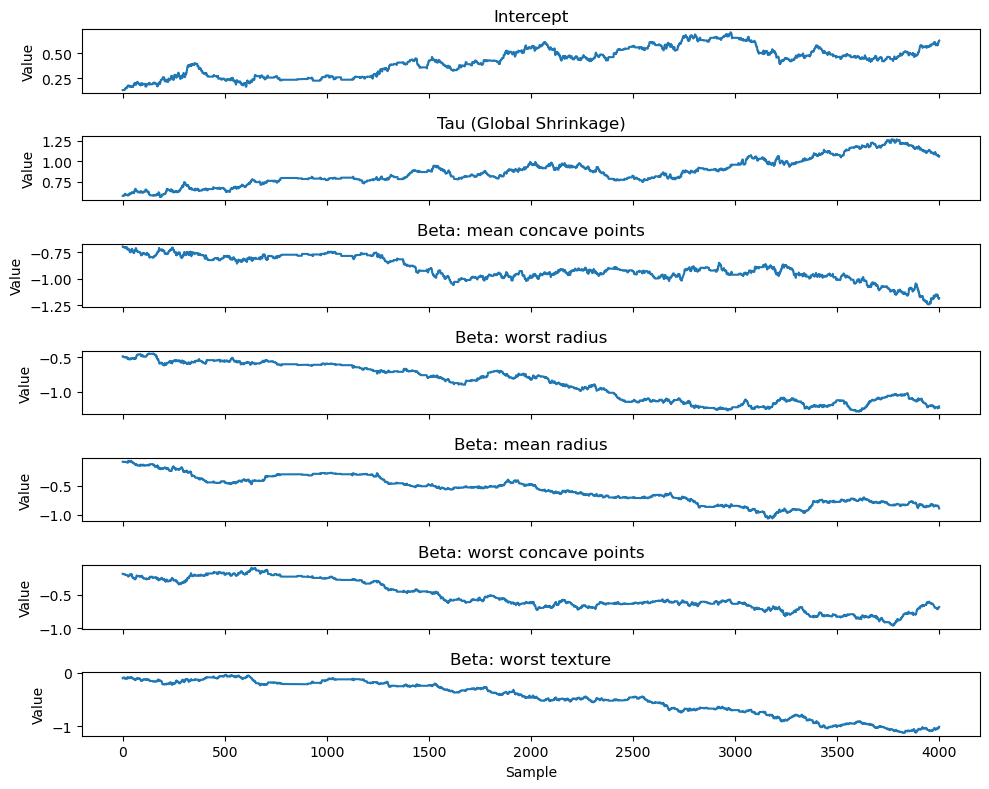

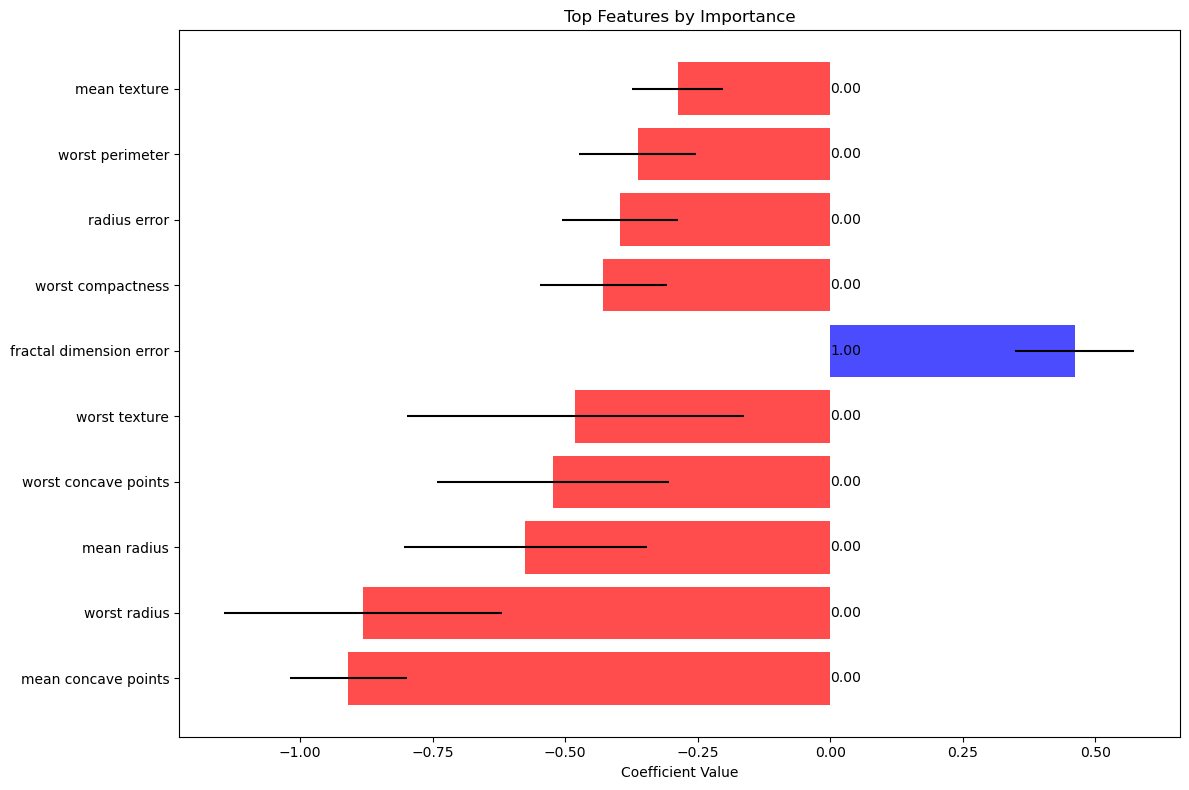

Accuracy: 0.9825


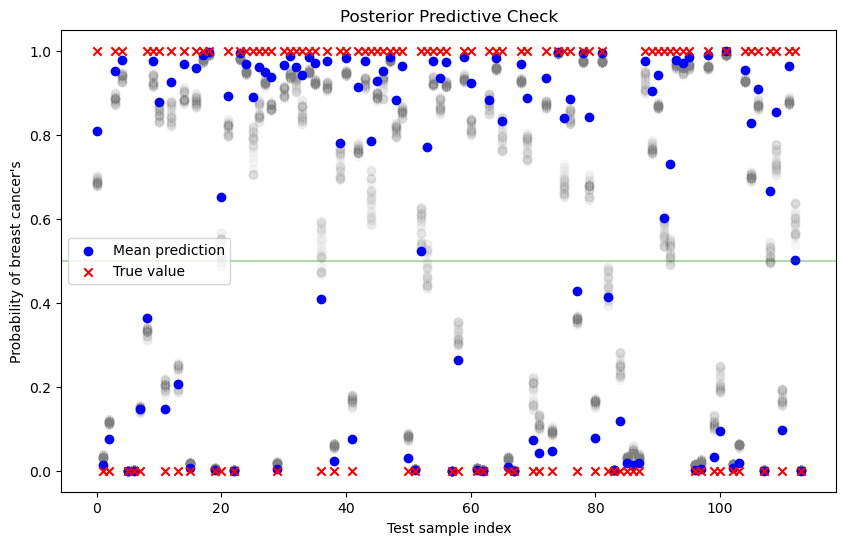

MCMC sampling completed. The posterior samples are ready for use in conformal prediction.


In [8]:
if __name__ == "__main__":
    main(dataset="breast", train_frac=0.8, n_steps=5000, seed=RANDOM_SEED)